In [1]:
#conncet to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# switch to working path
import os
repo_name = "hurricane-harm-herald"
target_dir = "/content/drive/MyDrive/ai4er/python/hurricane"
os.chdir(target_dir)
print(os.getcwd())

/content/drive/MyDrive/ai4er/python/hurricane


In [3]:
%cd /content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/notebooks

/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/notebooks


In [4]:
#install required packages
!pip install geopandas
!pip install cartopy
!pip install pandas==1.5.3
!pip install basemap
!pip install vptree 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 53.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 95.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 4.9 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp39-cp39-linux_x86_64.whl size=11113671 sha256=bcda0b34ec003641312de3863b70855ee5f998b9dffb426372e8e9e2f626c86f
  Stored in directory: /root/.cache/pip/wheels/74/b9/f5/2c94acd7cd21480e6cf63169144d7aac3e8d9cf63822

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for vptree: filename=vptree-1.3-py3-none-any.whl size=4562 sha256=1c413f01a1726e64e74929a9785668a7141affaa651348670981045db4b1bad8
  Stored in directory: /root/.cache/pip/wheels/66/58/32/f9f8d807f6b303ce68a51938c9e69b0ab9f592f1efc066ae29
Successfully built vptree


In [5]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import pickle
import cartopy.crs as ccrs
import math
import cartopy.feature as cfeature
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from geographiclib.geodesic import Geodesic
import math
import vptree

In [6]:
#df_xbd_points_path = '/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/xBD_data/xbd_points_posthurr_reformatted.pkl'
df_xbd_points_path ='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/processed_data/metadata_pickle/lnglat_pre_pol_post_damage.pkl'
building_data = pd.read_pickle(df_xbd_points_path)
df_noaa_xbd_hurricanes_path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/EFs/weather_data/noaa_xbd_hurricanes.pkl'
df_noaa_xbd_hurricanes=pd.read_pickle(df_noaa_xbd_hurricanes_path)
#group hurricane data
hurricane_groups = df_noaa_xbd_hurricanes.groupby('name')
for j, (hurricane_name,hurricane_data) in enumerate(hurricane_groups):
        print(hurricane_data.loc[hurricane_data.index[0], 'name'])

FLORENCE
HARVEY
MATTHEW
MICHAEL


In [7]:
#divide buildings into groups according to disaster name

building_locs=pd.DataFrame({'lat':building_data['geometry'].y,'lon':building_data['geometry'].x ,'disaster_name':building_data['disaster_name'],'damage_class':building_data['damage_class']})

# Standarize the name of hurricane
building_locs['disaster_name'] = building_locs['disaster_name'].replace('hurricane-florence', 'FLORENCE')
building_locs['disaster_name'] = building_locs['disaster_name'].replace('hurricane-michael', 'MICHAEL')
building_locs['disaster_name'] = building_locs['disaster_name'].replace('hurricane-matthew', 'MATTHEW')
building_locs['disaster_name'] = building_locs['disaster_name'].replace('hurricane-harvey', 'HARVEY')


building2tracks=pd.DataFrame({'lat':building_locs['lat'],'lon':building_locs['lon'] ,'disaster_name':building_locs['disaster_name'],'damage_class':building_locs['damage_class']})
building_groups = building2tracks.groupby('disaster_name')

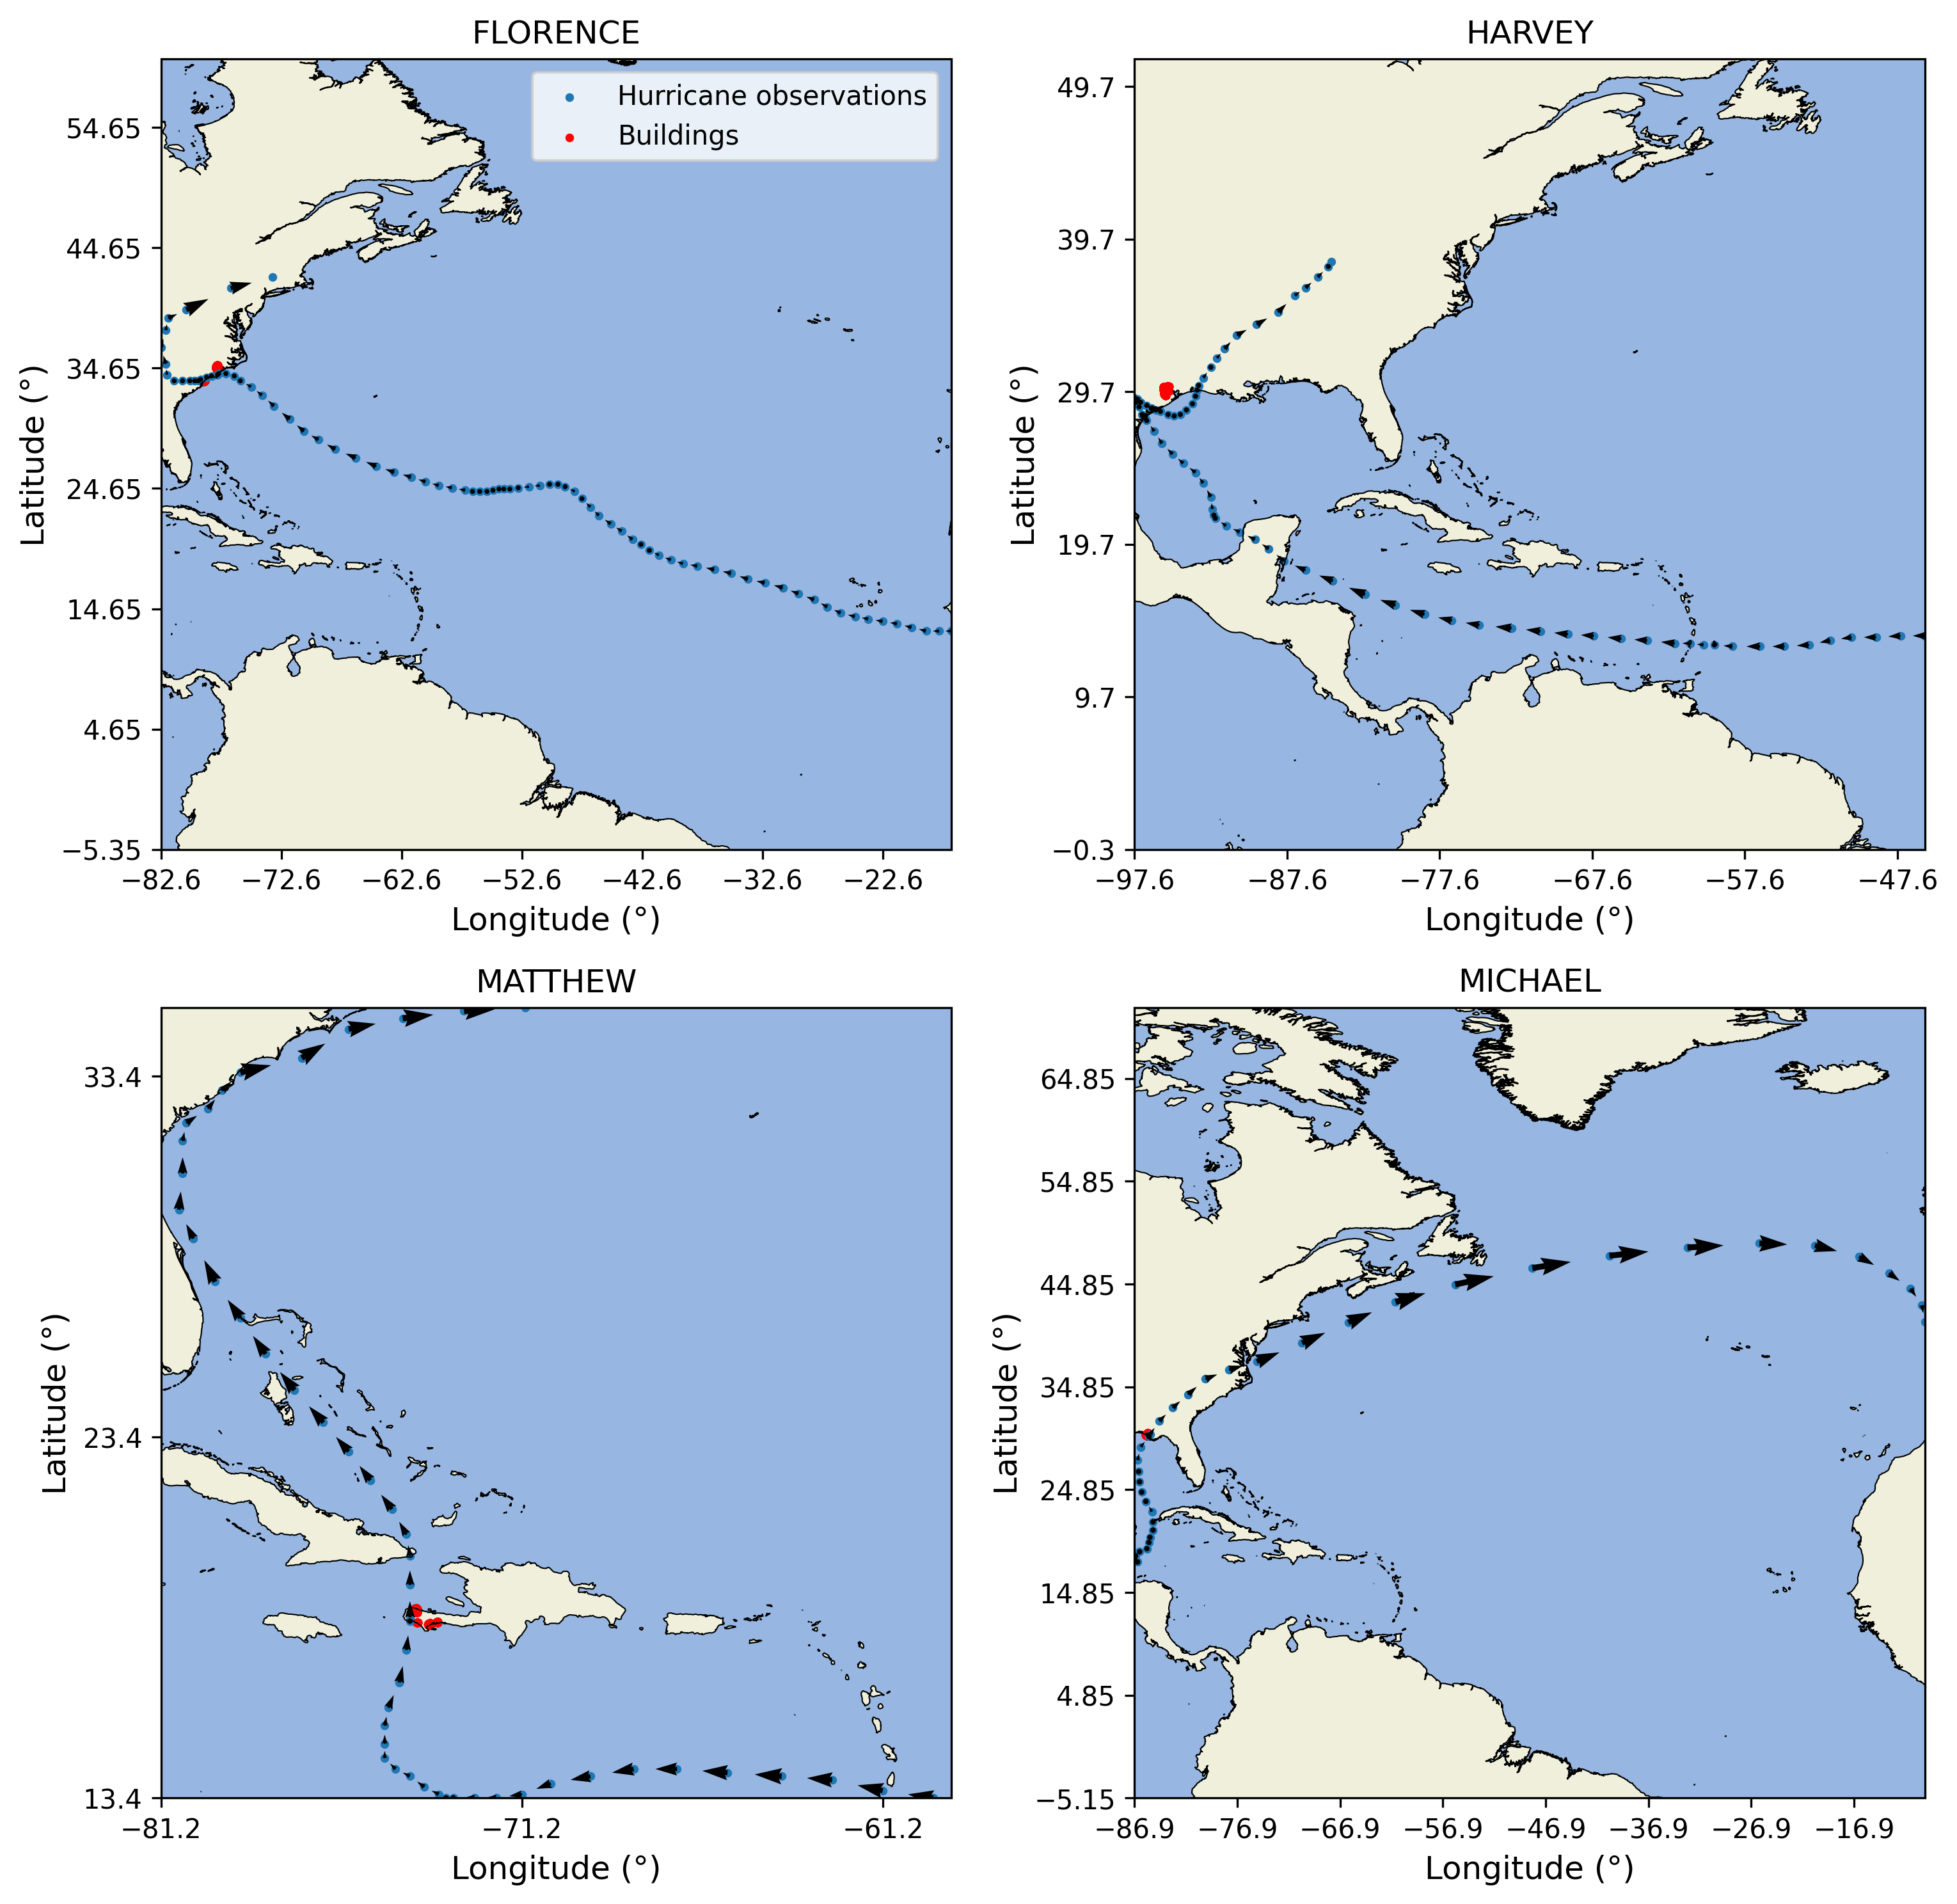

In [9]:
#plot original hurricane tracks and building locations

n_groups = len(building_groups) #group number
n_cols=2                        #column number
n_rows = math.ceil(n_groups / n_cols)   # raw number
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12),dpi=300,
                        subplot_kw={'projection': ccrs.PlateCarree()})

for i, (group_name, group_data) in enumerate(building_groups):

    for j, (hurricane_name,hurricane_data) in enumerate(hurricane_groups):
        if hurricane_data.loc[hurricane_data.index[0], 'name']==group_data.loc[group_data.index[0], 'disaster_name']:
            lon_list = list(group_data['lon'])+list(hurricane_data['lon'])
            lat_list = list(group_data['lat'])+list(hurricane_data['lat'])
            west=min(lon_list)
            east=max(lon_list)
            south=min(lat_list)
            north=max(lat_list)

    width=abs(east-west)
    height=abs(north-south)
    as_adj= 0.5*abs(width-height) #value to adjust aspect ratio

    dis_threshold=0 # add the extract space to the figure
    # plot the buildings and the choped hurricane data
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col]
    if width>height:
      ax.set_xlim(west-dis_threshold, east+dis_threshold)
      ax.set_ylim(south-dis_threshold-as_adj, north+dis_threshold+as_adj)
    else:
      ax.set_xlim(west-dis_threshold-as_adj, east+dis_threshold+as_adj)
      ax.set_ylim(south-dis_threshold, north+dis_threshold)

    #plot base map
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(cfeature.OCEAN.with_scale('10m'))

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    #plot the locations of buildings
    ax.scatter(group_data['lon'], group_data['lat'], s=5, transform=ccrs.PlateCarree(),c='red',label='Buildings')

    # plot hurricane track
    for j, (hurricane_name,hurricane_data) in enumerate(hurricane_groups):
        if hurricane_data.loc[hurricane_data.index[0], 'name']==group_data.loc[group_data.index[0], 'disaster_name']:
          ax.scatter(hurricane_data['lon'], hurricane_data['lat'], s=5, transform=ccrs.PlateCarree(),label='Hurricane observations')
          temp=np.array([hurricane_data['lon'],hurricane_data['lat']])
          temp=np.flip(temp, axis=1)
          x=temp[0,:]
          y=temp[1,:]
          ax.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=2)

    # Set x-label and y-label
    ax.set_title(group_data.loc[group_data.index[0], 'disaster_name'])
    ax.set_xlabel('Longitude (°)', fontsize=12)
    ax.set_ylabel('Latitude (°)', fontsize=12)
    # Set x-ticks and y-ticks

    xticks = np.arange(xlim[0],xlim[1], 10)
    yticks = np.arange(ylim[0],ylim[1], 10)

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    # add legend
    if i==0:
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = list(set(labels))
        handles = [handles[labels.index(label)] for label in unique_labels]
        ax.legend(handles, unique_labels)

while i < n_cols*n_rows-1:
    fig.delaxes(axs.flatten()[i+1])
    i += 1


plt.show()

In [10]:
# Define functions
# The function that interploate the lat and lon value at a series of points between the great circle of two reference points 
def interplatlon(lat1,lon1,lat2,lon2,step):
    geod = Geodesic.WGS84  # define the WGS84 ellipsoid
    l = geod.InverseLine(lat1, lon1, lat2, lon2) # create an inverse line defined by two points
    ds = step; # define the distance step 
    n = int(math.ceil(l.s13 / ds))

    # Initialize empty arrays
    s_arr = np.array([])
    lat_arr = np.array([])
    lon_arr = np.array([])

    for i in range(n + 1):
      s = min(ds * i, l.s13)
      g = l.Position(s, Geodesic.STANDARD | Geodesic.LONG_UNROLL)
      # Append values to arrays
      s_arr = np.append(s_arr, s)
      lat_arr = np.append(lat_arr, g['lat2'])
      lon_arr = np.append(lon_arr, g['lon2'])
    return s_arr,lat_arr,lon_arr

# The function that calculate Geodesic distance between two points
def geoddist(p1, p2):
  return Geodesic.WGS84.Inverse(p1[1], p1[0], p2[1], p2[0])['s12']

In [11]:
# interploate the hurricane track with varing step length (reslotuion)
res_list=np.append(np.arange(10,1,-2),np.arange(1,0,-0.2))*1000 #resolutions, unit: meters
#res_list=np.array([100000,50000,20000])
res_list = res_list.astype(int)

#creat a dictionary to store the dataframe that contain hurrican tracks at different resolution
track_list ={} 
for i in range(len(res_list)): 
    track_list[f'df_hurricane_track_interped_res{res_list[i]}'] = pd.DataFrame({'name':[],'lat':[],'lon':[]})

# interpolate
for k, (key, value) in enumerate(track_list.items()):
    for j, (hurricane_name,hurricane_track) in enumerate(hurricane_groups):
            temp=[]
            interped_track=np.empty((0,3))
            temp=np.array([hurricane_track['lon'],hurricane_track['lat']])# original 6-hour track
            temp=np.flip(temp, axis=1)
            for i in range(len(hurricane_track)-1):
              s_arr,lat_arr,lon_arr=interplatlon(temp[1,i],temp[0,i],temp[1,i+1],temp[0,i+1],res_list[k])
              temp1=np.array([s_arr,lat_arr,lon_arr]).T
              if i==len(hurricane_track)-1:
                interped_track = np.vstack((interped_track,temp1)) 
              else:
                interped_track = np.vstack((interped_track,temp1[:-1,:]))# delete the last row of the interpolated data to avoid repeat
            df_temp=pd.DataFrame({'name':hurricane_track.loc[hurricane_track.index[0], 'name'],'lat':interped_track[:,1],'lon':interped_track[:,2]})
            track_list[key] = pd.concat([track_list[key], df_temp])


In [25]:
# choose a hurricane, and plot the interploated tracks with different resolutions
Hurricane2plot='FLORENCE'
# Hurricane2plot='HARVEY'
# Hurricane2plot='MATTHEW'
# Hurricane2plot='MICHAEL'

n_groups = len(track_list) #
n_cols=2
n_rows = math.ceil(n_groups / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows),dpi=300,
                        subplot_kw={'projection': ccrs.PlateCarree()})

for i, (key, value) in enumerate(track_list.items()):
    temp_hurricane_groups = value.groupby('name')
    hurricane_data=temp_hurricane_groups.get_group(Hurricane2plot) #get the interpolated hurricane data
    group_data=building_groups.get_group(Hurricane2plot) #get building location data

    lon_list = list(group_data['lon'])+list(hurricane_data['lon'])
    lat_list = list(group_data['lat'])+list(hurricane_data['lat'])
    west=min(lon_list)
    east=max(lon_list)
    south=min(lat_list)
    north=max(lat_list)

    width=abs(east-west)
    height=abs(north-south)
    as_adj= 0.5*abs(width-height) #value to adjust aspect ratio

    dis_threshold=0 # add the extract space of the figure

    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col]

    if width>height:
      ax.set_xlim(west-dis_threshold, east+dis_threshold)
      ax.set_ylim(south-dis_threshold-as_adj, north+dis_threshold+as_adj)
    else:
      ax.set_xlim(west-dis_threshold-as_adj, east+dis_threshold+as_adj)
      ax.set_ylim(south-dis_threshold, north+dis_threshold)

    #plot base map
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(cfeature.OCEAN.with_scale('10m'))

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    #plot the locations of buildings
    ax.scatter(group_data['lon'], group_data['lat'], s=5, transform=ccrs.PlateCarree(),c='red',label='Buildings')

    # plot hurricane track
    ax.scatter(hurricane_data['lon'], hurricane_data['lat'], s=5, transform=ccrs.PlateCarree(),label='Interpolated hurricane track')
    temp=np.array([hurricane_data['lon'],hurricane_data['lat']])
    temp=np.flip(temp, axis=1)
    x=temp[0,:]
    y=temp[1,:]

    # Set x-label and y-label
    ax.set_title(f'{Hurricane2plot}, Res={res_list[i]}m')
    ax.set_xlabel('Longitude (°)', fontsize=12)
    ax.set_ylabel('Latitude (°)', fontsize=12)
    # Set x-ticks and y-ticks

    xticks = np.arange(xlim[0],xlim[1],(xlim[1]-xlim[0])/3)
    yticks = np.arange(ylim[0],ylim[1], (ylim[1]-ylim[0])/3)

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    # add legend
    if i==0:
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = list(set(labels))
        handles = [handles[labels.index(label)] for label in unique_labels]
        ax.legend(handles, unique_labels)
        
while i < n_cols*n_rows-1:
    fig.delaxes(axs.flatten()[i+1])
    i += 1

plt.show()



Output hidden; open in https://colab.research.google.com to view.

In [18]:
# search buildings' the shortest distance to hurricane tracks with varying resolutions

for k, (key, value) in enumerate(track_list.items()):
    temp_hurricane_groups = value.groupby('name') #group the interpolated hurricane data
    for i, (group_name, group_data) in enumerate(building_groups):
        west=(group_data['lon'].min())
        east=(group_data['lon'].max())
        south=(group_data['lat'].min())
        north=(group_data['lat'].max())

        dis_threshold=2 # assuming the building is not more than dis_threshold latitude and longitude away from the hurricane track, please change it according to your case

        hurricane_name=group_data.loc[group_data.index[0], 'disaster_name']
        hurricane_data=temp_hurricane_groups.get_group(hurricane_name) # get the hurricane track that corresponds to the building group

        # chop the hurricane track and only get the point data within the range defined by west, east, south, north and dis_threshold
        mask = (hurricane_data['lon'] >= west-dis_threshold) & (hurricane_data['lon'] <= east+dis_threshold) & \
              (hurricane_data['lat'] >= south-dis_threshold) & (hurricane_data['lat'] <= north+dis_threshold)
        points_within_range = hurricane_data[mask]

        # convert data to nd array to reduce computational time
        points_within_range = np.column_stack((points_within_range['lon'], points_within_range['lat']))
        buildings = np.column_stack((group_data['lon'], group_data['lat']))

        calculate_dis_to_hurricanes=True  # the switch for whether or not to calculate the shortest distance to the hurricanes
        if calculate_dis_to_hurricanes:
            closestp=np.zeros([len(buildings),2])# to store the closest point in the hurricane track to a given building
            distance=np.zeros([len(buildings),1])# to store the building's distance to the hurricane track
            hurricane_vp = vptree.VPTree(points_within_range, geoddist)  #build the lookup table

            for j in range(0,len(buildings)):
                  data = hurricane_vp.get_nearest_neighbor(buildings[j,:])   # find buildings' closest distance on the hurricane 
                  closestp[j,:]=data[1]
                  distance[j]=data[0] #distance in unit of meter

            building2tracks.loc[group_data.index, f'closestp_lon_res{res_list[k]}'] = closestp[:,0]  # store the calculated data into dataframe
            building2tracks.loc[group_data.index, f'closestp_lat_res{res_list[k]}'] = closestp[:,1]
            building2tracks.loc[group_data.index, f'dis2hurricane_res{res_list[k]}'] = distance[:,0]



In [22]:
# write data to file
path='/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/datasets/processed_data/shortest_dis2hurricanes_varying_res.pkl'
shortest_dis2hurricanes_varying_res=pd.DataFrame({'xbd_observation_lat':building2tracks['lat'],'xbd_observation_lon':building2tracks['lon'],
                                      'disaster_name':building2tracks['disaster_name'],'damage_class':building2tracks['damage_class']})
for i in range(len(res_list)):
  shortest_dis2hurricanes_varying_res[f'dis2hurricane_res{res_list[i]}m']=building2tracks[f'dis2hurricane_res{res_list[i]}']


shortest_dis2hurricanes_varying_res.to_pickle(path) # store the dataframe
# read the stored data for test
with open(path, 'rb') as f:
    shortest_dis2hurricanes_test = pickle.load(f)
    
shortest_dis2hurricanes_test

xbd_observation_lat  xbd_observation_lon disaster_name damage_class  \
0                30.207242           -85.673910       MICHAEL            2   
1                30.207529           -85.674335       MICHAEL            0   
2                30.207669           -85.673908       MICHAEL            0   
3                30.207543           -85.673923       MICHAEL            0   
4                30.207487           -85.673919       MICHAEL            0   
...                    ...                  ...           ...          ...   
23049            30.115500           -85.679114       MICHAEL            0   
23050            30.115448           -85.678953       MICHAEL            1   
23051            30.114085           -85.679504       MICHAEL            1   
23052            30.113815           -85.679370       MICHAEL            2   
23053            30.115842           -85.679238       MICHAEL            0   

       dis2hurricane_res10000m  dis2hurricane_res8000m  \
0                 24909.315207            24566.180479   
1                 24961.048231            24615.465472   
2                 24935.424295            24582.025827   
3                 24928.814789            24578.591569   
4                 24925.090944            24576.159879   
...                        ...                     ...   
23049             21500.100782            21169.756886   
23050             21484.204429            21153.275053   
23051             21437.456638            21166.297861   
23052             21409.435461            21146.359449   
23053             21532.277106            21191.114688   

       dis2hurricane_res6000m  dis2hurricane_res4000m  dis2hurricane_res2000m  \
0                24633.617342            24566.180479            24518.486558   
1                24684.874701            24615.465472            24568.925690   
2                24656.485841            24582.025827            24537.912782   
3                24650.888394            24578.591569            24533.380339   
4                24647.569659            24576.159879            24530.494940   
...                       ...                     ...                     ...   
23049            20968.609435            20957.254777            20957.254777   
23050            20952.054488            20940.776019            20940.776019   
23051            20949.947584            20923.393932            20923.393932   
23052            20927.670993            20898.954035            20898.954035   
23053            20993.029533            20984.546871            20984.546871   

       dis2hurricane_res1000m  dis2hurricane_res800m  dis2hurricane_res600m  \
0                24518.486558           24514.983058           24514.983058   
1                24568.925690           24565.217664           24565.217664   
2                24537.912782           24533.701980           24533.701980   
3                24533.380339           24529.387203           24529.387203   
4                24530.494940           24526.591195           24526.591195   
...                       ...                    ...                    ...   
23049            20939.067752           20938.886140           20938.886140   
23050            20922.532050           20922.358819           20922.358819   
23051            20912.779880           20911.077761           20911.077761   
23052            20889.395636           20887.477985           20887.477985   
23053            20964.952940           20965.057679           20965.057679   

       dis2hurricane_res400m  dis2hurricane_res200m  
0               24514.983058           24514.983058  
1               24565.217664           24565.217664  
2               24533.701980           24533.701980  
3               24529.387203           24529.387203  
4               24526.591195           24526.591195  
...                      ...                    ...  
23049           20938.886140           20938.886140  
23050           209

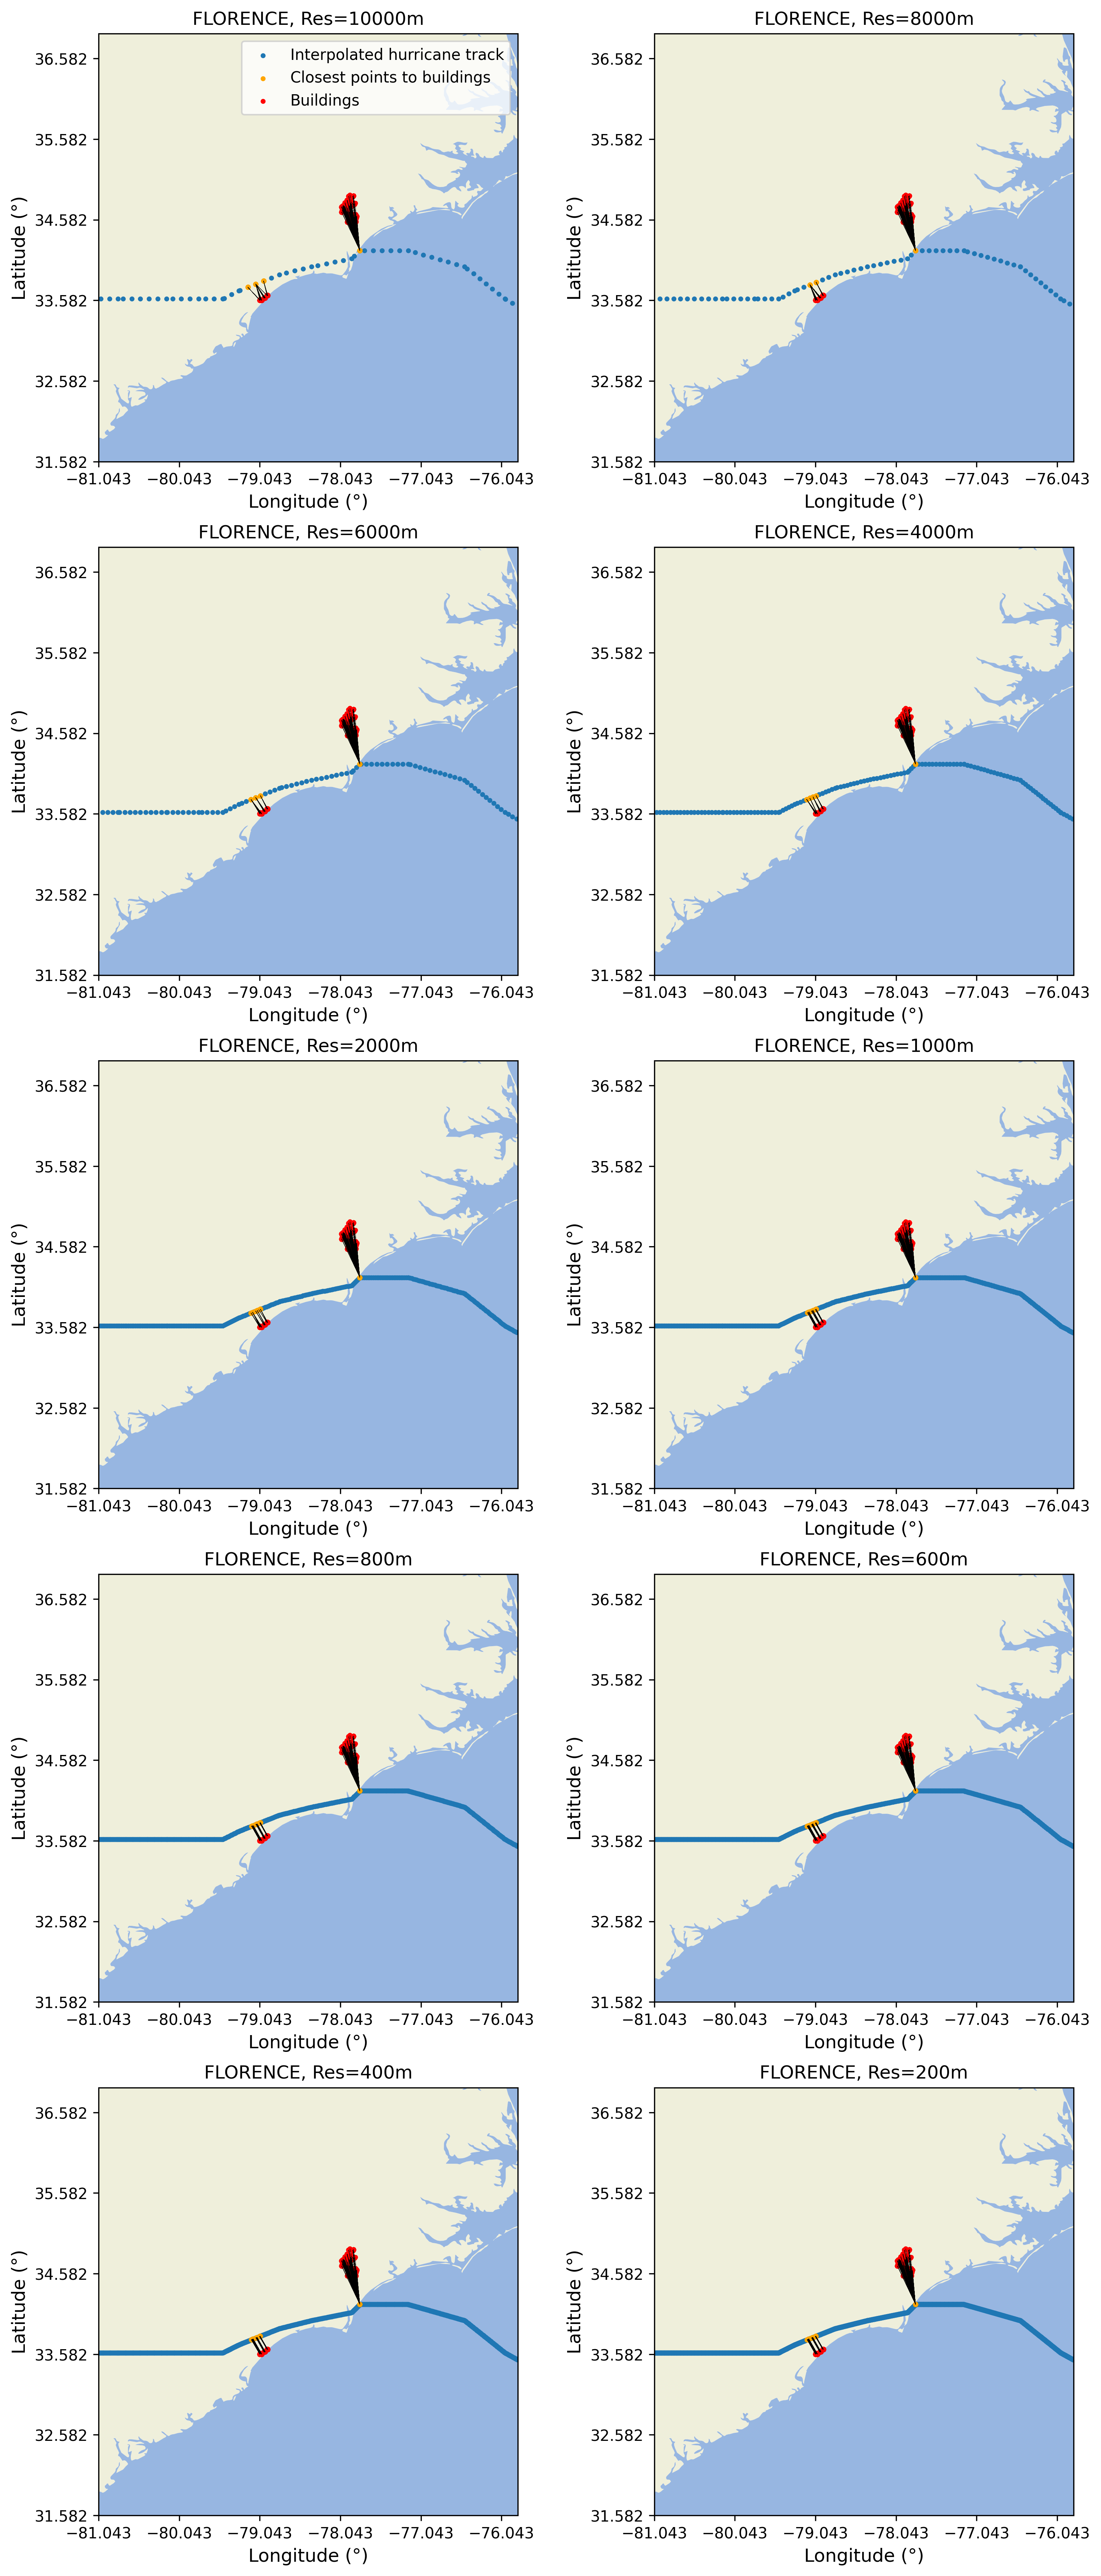

In [21]:
# Choose a hurricane to plot buildings' shortest distance to hurricane tracks

Hurricane2plot='FLORENCE'
#Hurricane2plot='MATTHEW'

n_groups = len(track_list) #
n_cols=2
n_rows = math.ceil(n_groups / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows),dpi=300,
                        subplot_kw={'projection': ccrs.PlateCarree()})

for k, (key, value) in enumerate(track_list.items()):
    temp_hurricane_groups = value.groupby('name')

    for i, (group_name, group_data) in enumerate(building_groups):
            
        hurricane_name=group_data.loc[group_data.index[0], 'disaster_name']

        if hurricane_name==Hurricane2plot:
            west=(group_data['lon'].min())
            east=(group_data['lon'].max())
            south=(group_data['lat'].min())
            north=(group_data['lat'].max())

            hurricane_data=temp_hurricane_groups.get_group(hurricane_name)

            # chop the hurricane track and only get the point data within the range defined by west, east, south, north and dis_threshold
            mask = (hurricane_data['lon'] >= west-dis_threshold) & (hurricane_data['lon'] <= east+dis_threshold) & \
                  (hurricane_data['lat'] >= south-dis_threshold) & (hurricane_data['lat'] <= north+dis_threshold)
            points_within_range = hurricane_data[mask]

            # plot the buildings and the choped hurricane track
            row = k // n_cols
            col = k % n_cols
            ax = axs[row, col]
            ax.set_xlim(west-dis_threshold, east+dis_threshold)
            ax.set_ylim(south-dis_threshold, north+dis_threshold)
            ax.add_feature(cfeature.LAND.with_scale('10m'))
            ax.add_feature(cfeature.OCEAN.with_scale('10m'))
            ax.scatter(points_within_range['lon'], points_within_range['lat'], s=5, transform=ccrs.PlateCarree(),label='Interpolated hurricane track')
            ax.scatter(group_data['lon'], group_data['lat'], s=5, transform=ccrs.PlateCarree(),c='red',label='Buildings')
            # Set x-label and y-label
            ax.set_title(f'{Hurricane2plot}, Res={res_list[k]}m')
            ax.set_xlabel('Longitude (°)', fontsize=12)
            ax.set_ylabel('Latitude (°)', fontsize=12)
            # Set x-ticks and y-ticks
            xticks = np.arange(west-dis_threshold, east+dis_threshold, 1)
            yticks = np.arange(south-dis_threshold, north+dis_threshold, 1)
            ax.set_xticks(xticks, crs=ccrs.PlateCarree())
            ax.set_yticks(yticks, crs=ccrs.PlateCarree())
            ax.scatter(group_data[f'closestp_lon_res{res_list[k]}'], group_data[f'closestp_lat_res{res_list[k]}'], s=5, transform=ccrs.PlateCarree(),c='orange',label='Closest points to buildings')
            ax.plot([group_data['lon'],group_data[f'closestp_lon_res{res_list[k]}']],[group_data['lat'],group_data[f'closestp_lat_res{res_list[k]}']],'k',linewidth=0.1)
            if k==0:
                handles, labels = ax.get_legend_handles_labels()
                unique_labels = list(set(labels))
                handles = [handles[labels.index(label)] for label in unique_labels]
                ax.legend(handles, unique_labels)
                plot_legend=False


while k < n_cols*n_rows-1:
        fig.delaxes(axs.flatten()[k+1])
        k += 1
plt.show() 




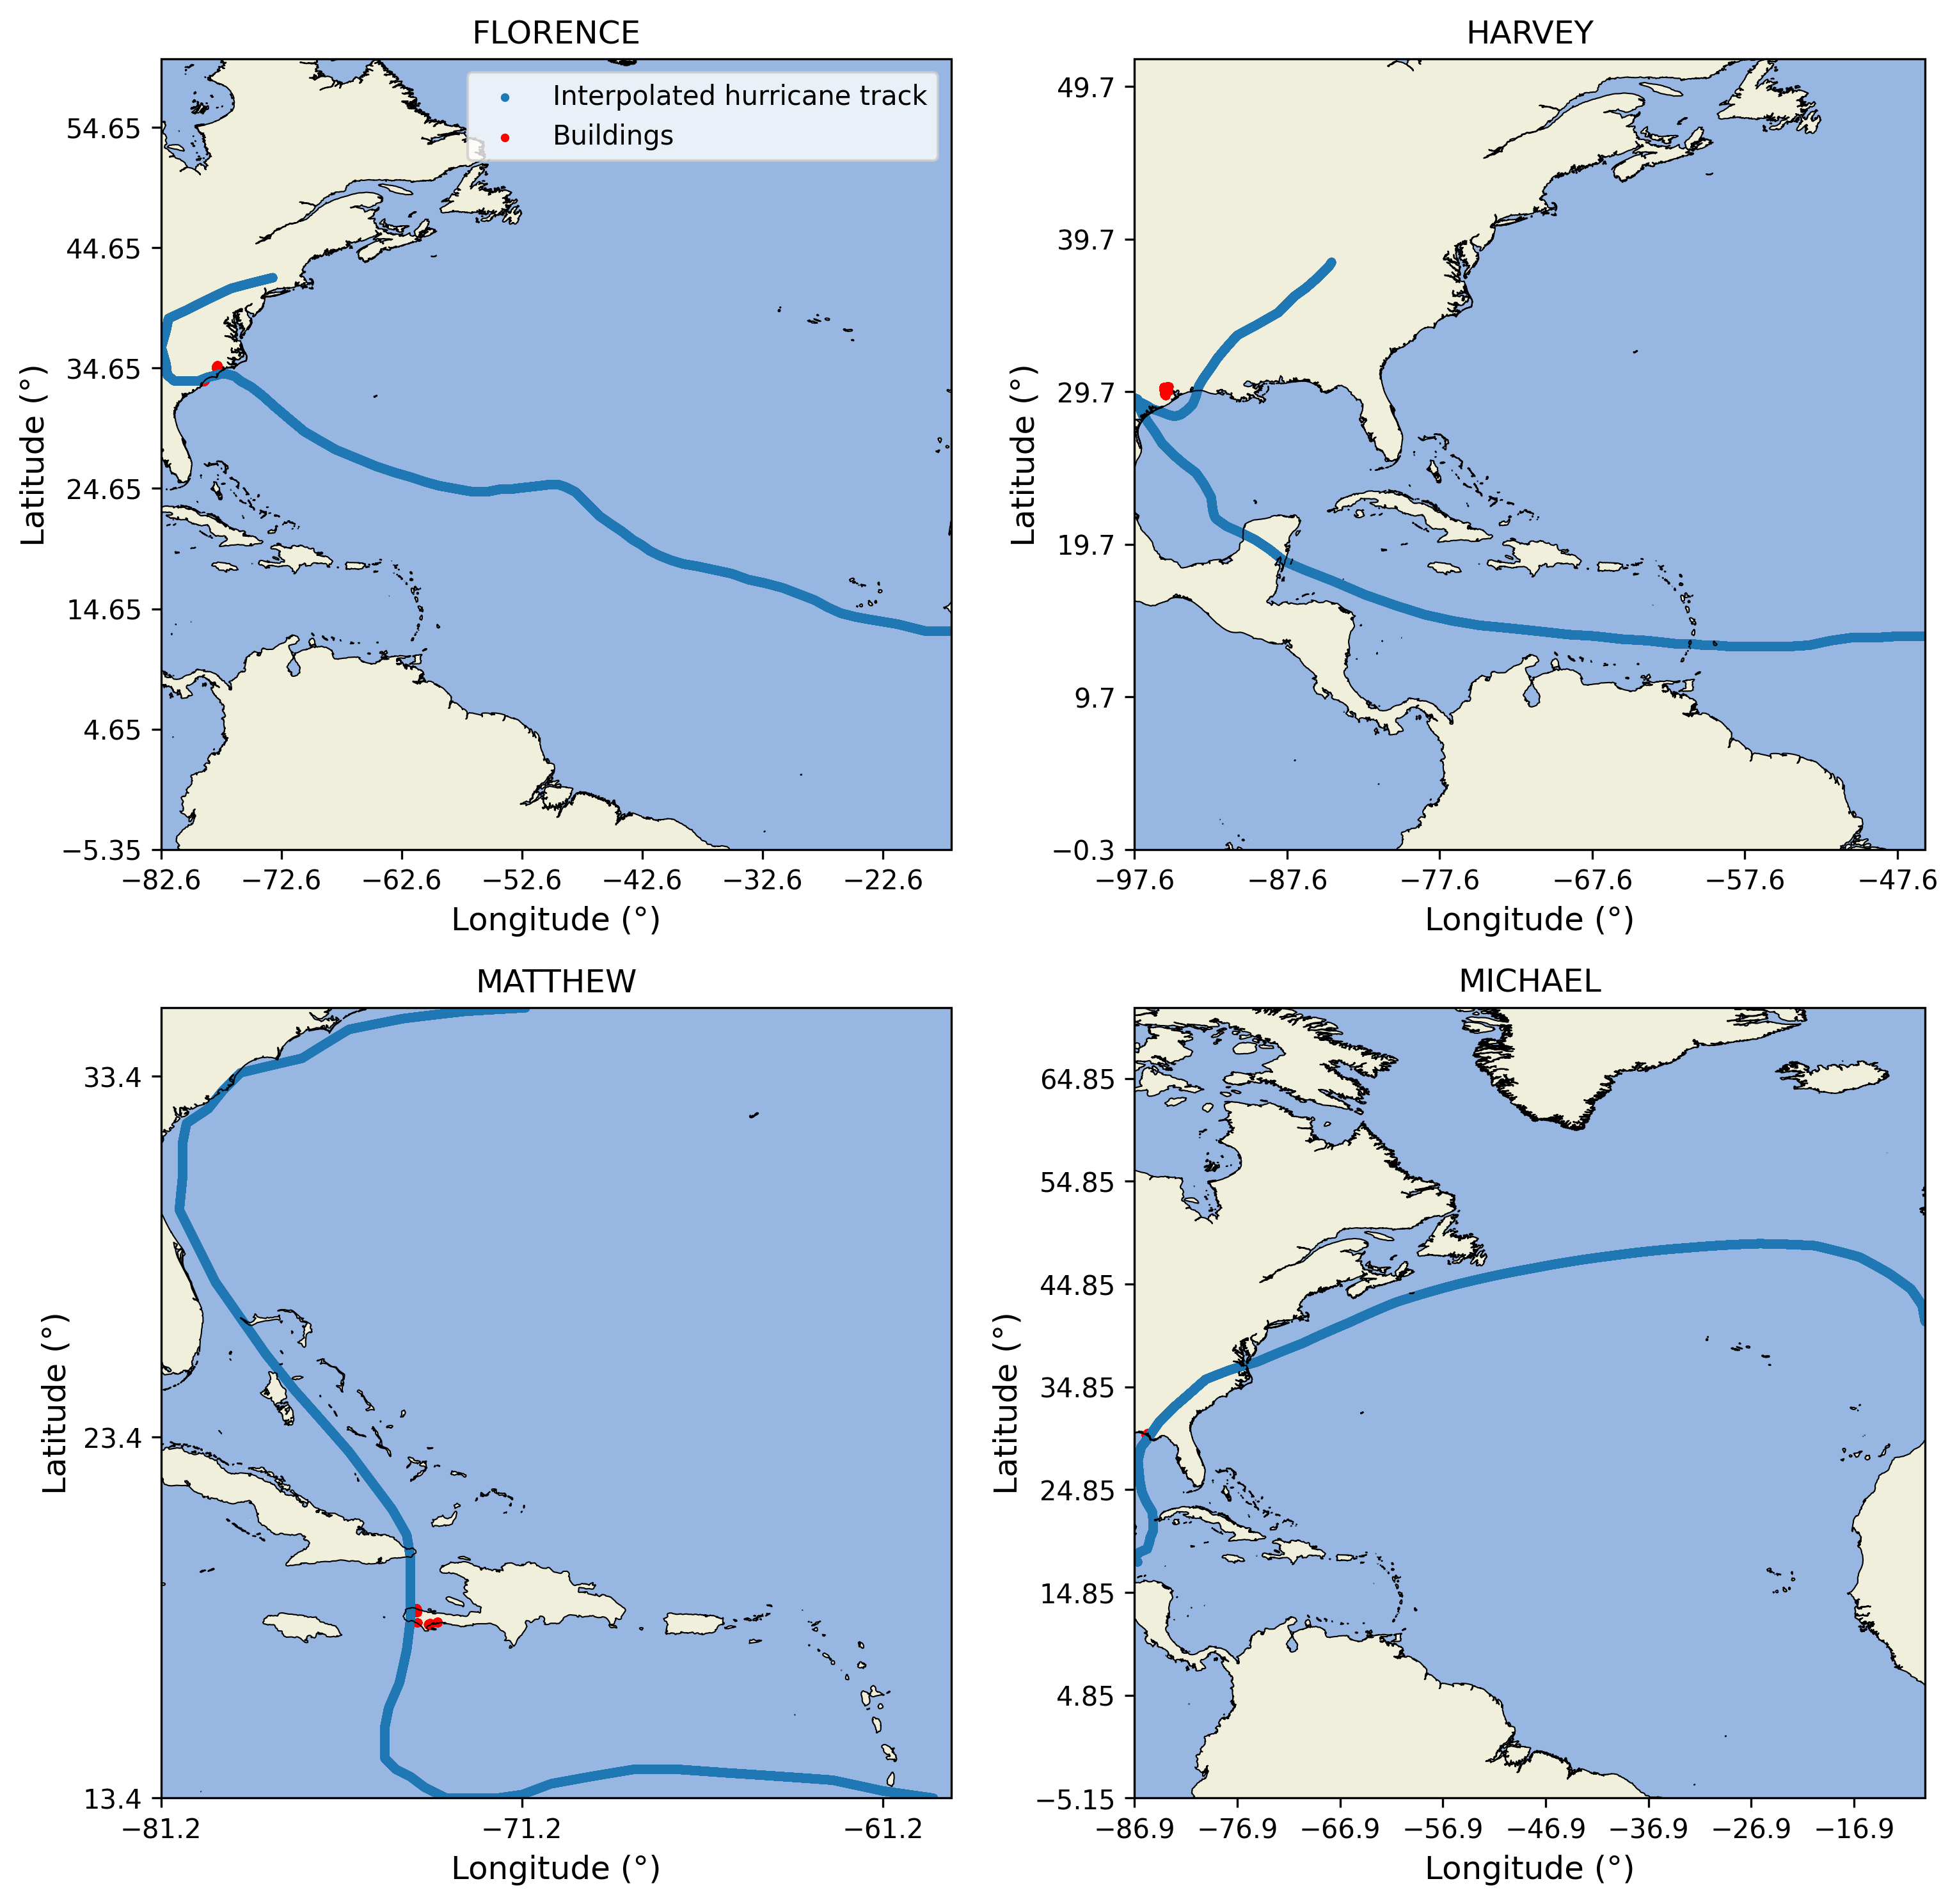

In [23]:
# plot the interploted hurricane tracks with a given resolution

res=res_list[-1]# change the index of res_list to change resolution of the track

hurricane_track_interped=track_list[f'df_hurricane_track_interped_res{res}'] # get the track with given resolution
hurricane_track_interped_groups = hurricane_track_interped.groupby('name')   # group the track according to hurricane name

n_groups = len(building_groups) #group number
n_cols=2                        #column number
n_rows = math.ceil(n_groups / n_cols)   # raw number
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12),dpi=300,
                        subplot_kw={'projection': ccrs.PlateCarree()})

for i, (group_name, group_data) in enumerate(building_groups):
    hurricane_name=group_data.loc[group_data.index[0], 'disaster_name']
    hurricane_data=hurricane_track_interped_groups.get_group(hurricane_name)

    lon_list = list(group_data['lon'])+list(hurricane_data['lon'])
    lat_list = list(group_data['lat'])+list(hurricane_data['lat'])
    west=min(lon_list)
    east=max(lon_list)
    south=min(lat_list)
    north=max(lat_list)

    width=abs(east-west)
    height=abs(north-south)
    as_adj= 0.5*abs(width-height) #value to adjust aspect ratio

    dis_threshold=0 # add the extract space of the figure
    # plot the buildings and the choped hurricane track
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col]
    if width>height:
      ax.set_xlim(west-dis_threshold, east+dis_threshold)
      ax.set_ylim(south-dis_threshold-as_adj, north+dis_threshold+as_adj)
    else:
      ax.set_xlim(west-dis_threshold-as_adj, east+dis_threshold+as_adj)
      ax.set_ylim(south-dis_threshold, north+dis_threshold)

    #plot base map
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(cfeature.OCEAN.with_scale('10m'))

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    #plot the locations of buildings
    ax.scatter(group_data['lon'], group_data['lat'], s=5, transform=ccrs.PlateCarree(),c='red',label='Buildings')

    # plot hurricane track
    ax.scatter(hurricane_data['lon'], hurricane_data['lat'], s=5, transform=ccrs.PlateCarree(),label='Interpolated hurricane track')
    temp=np.array([hurricane_data['lon'],hurricane_data['lat']])
    temp=np.flip(temp, axis=1)
    x=temp[0,:]
    y=temp[1,:]
    # using arrows to plot the track
    #ax.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=2,width=0.01)

    # Set x-label and y-label
    ax.set_title(group_data.loc[group_data.index[0], 'disaster_name'])
    ax.set_xlabel('Longitude (°)', fontsize=12)
    ax.set_ylabel('Latitude (°)', fontsize=12)
    # Set x-ticks and y-ticks

    xticks = np.arange(xlim[0],xlim[1], 10)
    yticks = np.arange(ylim[0],ylim[1], 10)

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    # add legend
    if i==0:
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = list(set(labels))
        handles = [handles[labels.index(label)] for label in unique_labels]
        ax.legend(handles, unique_labels)

while i < n_cols*n_rows-1:
    fig.delaxes(axs.flatten()[i+1])
    i += 1

plt.show()

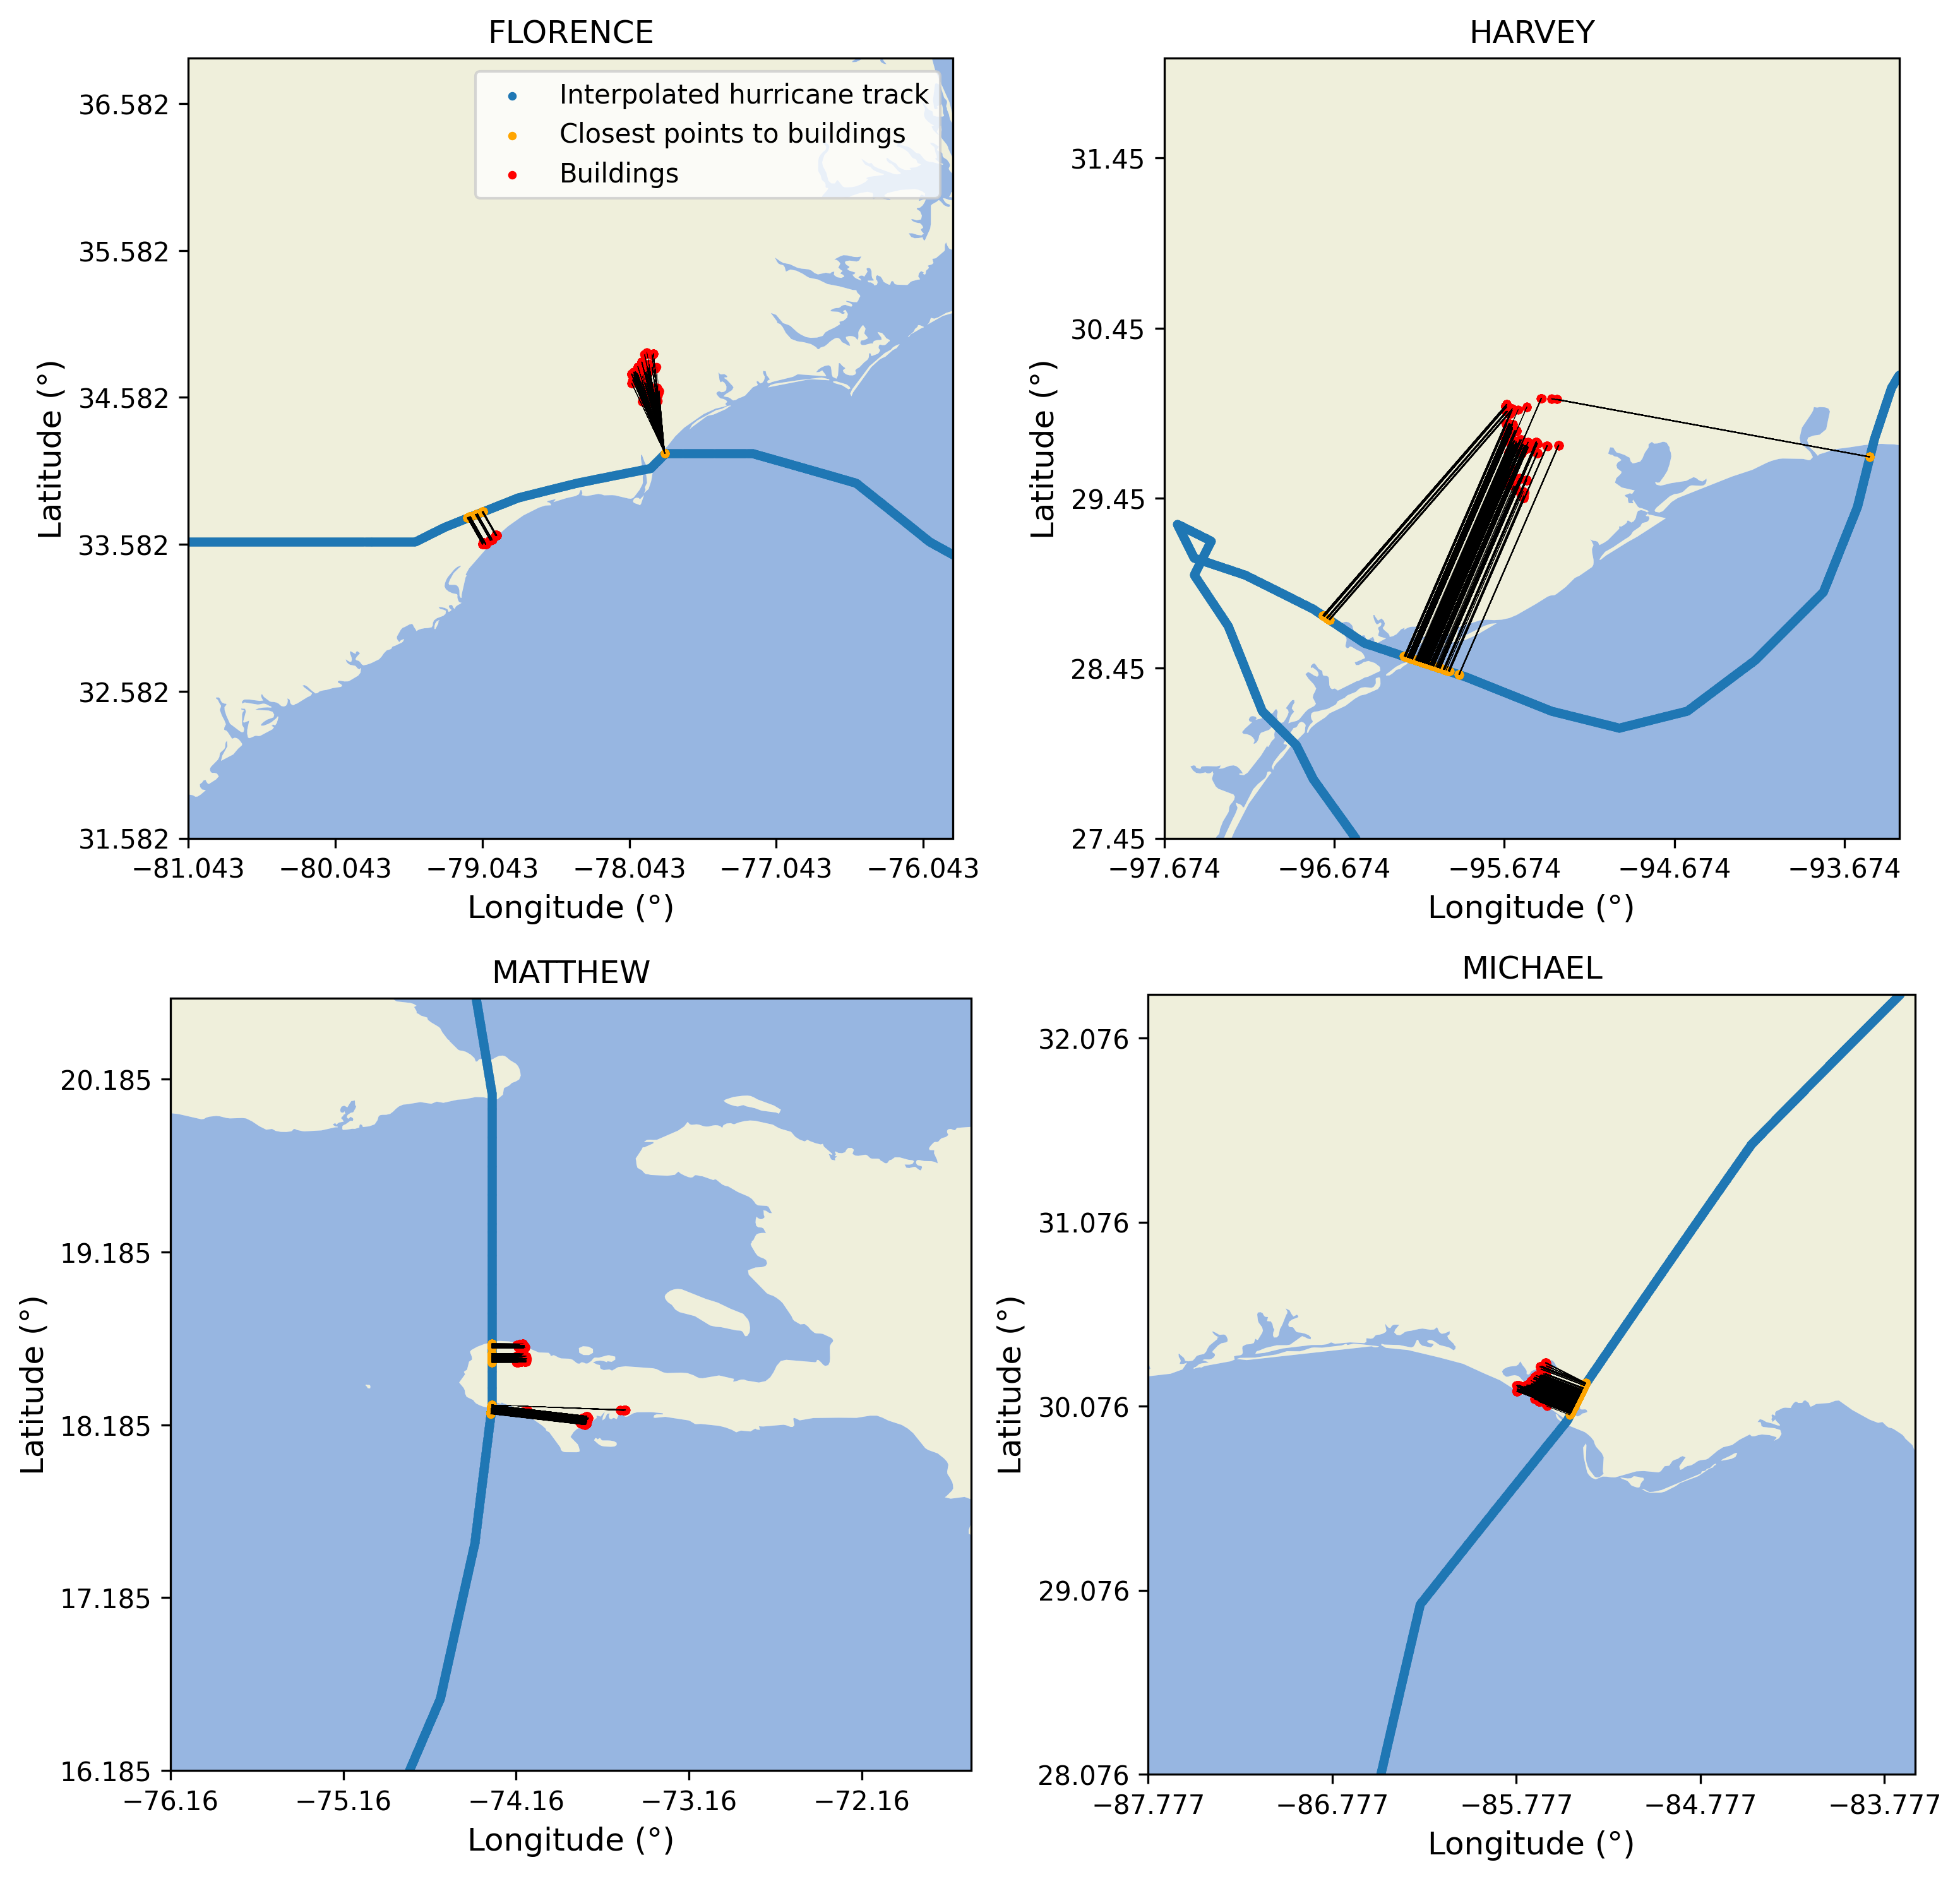

In [24]:
# plot buildings' the shortest distance to hurricane track at a given resolution

n_groups = len(building_groups) #
n_cols=2
n_rows = math.ceil(n_groups / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12),dpi=300,
                        subplot_kw={'projection': ccrs.PlateCarree()})

for i, (group_name, group_data) in enumerate(building_groups):
    west=(group_data['lon'].min())
    east=(group_data['lon'].max())
    south=(group_data['lat'].min())
    north=(group_data['lat'].max())

    dis_threshold=2 # variable to adjust the plotted data range

    hurricane_name=group_data.loc[group_data.index[0], 'disaster_name']
    hurricane_data=hurricane_track_interped_groups.get_group(hurricane_name)

    # chop the hurricane track and only get the point data within the range defined by west, east, south, north and dis_threshold
    mask = (hurricane_data['lon'] >= west-dis_threshold) & (hurricane_data['lon'] <= east+dis_threshold) & \
          (hurricane_data['lat'] >= south-dis_threshold) & (hurricane_data['lat'] <= north+dis_threshold)
    points_within_range = hurricane_data[mask]

    # plot the buildings and the choped hurricane track
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col]
    ax.set_xlim(west-dis_threshold, east+dis_threshold)
    ax.set_ylim(south-dis_threshold, north+dis_threshold)
    ax.add_feature(cfeature.LAND.with_scale('10m'))
    ax.add_feature(cfeature.OCEAN.with_scale('10m'))
    ax.scatter(points_within_range['lon'], points_within_range['lat'], s=5, transform=ccrs.PlateCarree(),label='Interpolated hurricane track')
    ax.scatter(group_data['lon'], group_data['lat'], s=5, transform=ccrs.PlateCarree(),c='red',label='Buildings')
    # Set x-label and y-label
    ax.set_title(group_data.loc[group_data.index[0], 'disaster_name'])
    ax.set_xlabel('Longitude (°)', fontsize=12)
    ax.set_ylabel('Latitude (°)', fontsize=12)
    # Set x-ticks and y-ticks
    xticks = np.arange(west-dis_threshold, east+dis_threshold, 1)
    yticks = np.arange(south-dis_threshold, north+dis_threshold, 1)

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    ax.scatter(group_data[f'closestp_lon_res{res}'], group_data[f'closestp_lat_res{res}'], s=5, transform=ccrs.PlateCarree(),c='orange',label='Closest points to buildings')
    ax.plot([group_data['lon'],group_data[f'closestp_lon_res{res}']],[group_data['lat'],group_data[f'closestp_lat_res{res}']],'k',linewidth=0.1)
    # add legend
    if i==0:
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = list(set(labels))
        handles = [handles[labels.index(label)] for label in unique_labels]
        ax.legend(handles, unique_labels)

while i < n_cols*n_rows-1:
    fig.delaxes(axs.flatten()[i+1])
    i += 1
plt.show()

